 # Introduction to  NLP with BoW

In this tutorial, we will cover:

- Simple BoW model on ready processed `keras.datasets.imdb`.
- NLP data pre-processing on `aclimbd` raw data set.
- Text binarization using keras `Tokenizer`
- Text features using both sklearn and keras Tokenizer: `binary`, `count`, `freq` and `tfidf`
- Introduce Keras `Embedding` layer and how to use it with Bag-of-word vectors model.

In [4]:
# import necassery libraries 

from tensorflow.keras.datasets import imdb 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [30]:
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words = 10000)


The argument num_words=10000 means that we will only keep the  top 10,000 most frequently occurring words in the training data.  Rare words will be discarded. This allows us to work with vector data of manageable size.

The variables train_data and test_data are lists of reviews, each review being a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [7]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [8]:
train_labels[0]

1




Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000 let's check that:

In [9]:
max([max(sequence) for sequence in train_data ])

9999

For kicks, here's how you can quickly 


decode one of these reviews back to English words:

In [17]:
# word_index is a dictionary mapping words to an integer index
words_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_index = dict([(value,key)for (value,key) in words_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknow
decoded_review = ' '.join([reverse_index.get(i - 3 ,'?') for i in train_data[0]])

In [19]:
decoded_review

'?'

## Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [21]:
def vectorize_sentences(sequences,dimension = 10000):
        # Create an all-zero matrix of shape (len(sequences), dimension)

    results = np.zeros((len(sequences),dimension))
    for i,sequences in enumerate(sequences):
        results[i,sequences] = 1
    return results

# Our vectorized training data
x_train = vectorize_sentences(train_data)
# Our vectorized test data
x_test = vectorize_sentences(test_data)

In [22]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [31]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [32]:
# import necaasry libries for model 
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


In [33]:
model.compile(
    optimizer = 'rmsprop',
    loss='binary_crossentropy',
    metrics =['accuracy']
)

In [34]:
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers
model.compile(
  optimizer=optimizers.RMSprop(lr=0.001),
    loss = losses.binary_crossentropy,
    metrics = [metrics.binary_accuracy]
)

c:\Users\PC1\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Validating our approach
In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:



In [35]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [36]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 41ms/step - loss: 0.4902 - binary_accuracy: 0.7986 - val_loss: 0.3737 - val_binary_accuracy: 0.8704
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2989 - binary_accuracy: 0.9047 - val_loss: 0.3706 - val_binary_accuracy: 0.8390
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2264 - binary_accuracy: 0.9277 - val_loss: 0.2792 - val_binary_accuracy: 0.8896
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1782 - binary_accuracy: 0.9429 - val_loss: 0.2757 - val_binary_accuracy: 0.8876
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1439 - binary_accuracy: 0.9562 - val_loss: 0.2789 - val_binary_accuracy: 0.8883
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1196 - binary_accuracy: 0.9625 - val_loss: 0.2979 - val_binary_accuracy: 0.8823
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - los

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

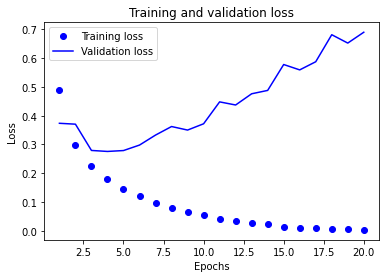

In [41]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

# bo is for 'blue dot'

plt.plot(epochs,loss,'bo',label = 'Training loss')

# b is for "solid blue line"
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

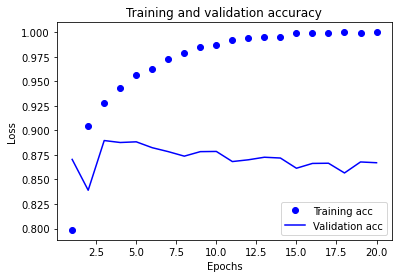

In [42]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()